In [7]:
%reset -f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
import os
import pyprojroot
root=pyprojroot.here()
sys.path.insert(0,root.as_posix())
from pathlib import Path
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import json
from scipy import integrate
from py_utils.excel_functions import get_sheetnames_xlsx
from py_utils.plotting_functions import TUFLOW_get_long_section

In [54]:
ls_cfg_ = {
    'respath' : 'L:\\A11650.L.iat.CoorongRelease\\05_modelling\\post_processing\\output\\python\\longseries',
    'resfile' : 'Coorong_Release_Export_longseries_SaltCreekScns.xlsx',
    'outpath' : 'L:\\A11650.L.iat.CoorongRelease\\05_modelling\\post_processing\\output\\python\\longseries\\ls_plots',
    
    'scenarios' : ['Base', '4.1a', '4.1b', '4.2', '4.3'],
    'variables' : ['Water Level', 'Salinity'],
    'periods' : ['2018_Aug_Dec', '2019_Jan_Mar'],
    #'periods' : ['2018_Jan_Mar', '2018_Apr_Jul', '2018_Aug_Dec', '2019_Jan_Mar'],
    'ylabel' : ['Water Level (mAHD)', 'Salinity (g/L)'],
    'ylim' : [[-0.2, 0.5], [0, 120]],
    'xlim' : [0, 107]
}
ls_cfg_

{'respath': 'L:\\A11650.L.iat.CoorongRelease\\05_modelling\\post_processing\\output\\python\\longseries',
 'resfile': 'Coorong_Release_Export_longseries_SaltCreekScns.xlsx',
 'outpath': 'L:\\A11650.L.iat.CoorongRelease\\05_modelling\\post_processing\\output\\python\\longseries\\ls_plots',
 'scenarios': ['Base', '4.1a', '4.1b', '4.2', '4.3'],
 'variables': ['Water Level', 'Salinity'],
 'periods': ['2018_Aug_Dec', '2019_Jan_Mar'],
 'ylabel': ['Water Level (mAHD)', 'Salinity (g/L)'],
 'ylim': [[-0.2, 0.5], [0, 120]],
 'xlim': [0, 107]}

In [55]:
outpath = Path(ls_cfg_.get('outpath'))
outpath.mkdir(exist_ok=True)

ls_cfg_file = ls_cfg_.get('resfile').replace(' ','_')+'.json'
with open(outpath / ls_cfg_file,"w") as f:
    ls_cfg_json = json.dumps(ls_cfg_)
    f.write(ls_cfg_json)
    f.close()

with open(outpath / ls_cfg_file) as f:
    ls_cfg = json.load(f)
    f.close()

display(ls_cfg_file)
display(ls_cfg)

'Coorong_Release_Export_longseries_SaltCreekScns.xlsx.json'

{'respath': 'L:\\A11650.L.iat.CoorongRelease\\05_modelling\\post_processing\\output\\python\\longseries',
 'resfile': 'Coorong_Release_Export_longseries_SaltCreekScns.xlsx',
 'outpath': 'L:\\A11650.L.iat.CoorongRelease\\05_modelling\\post_processing\\output\\python\\longseries\\ls_plots',
 'scenarios': ['Base', '4.1a', '4.1b', '4.2', '4.3'],
 'variables': ['Water Level', 'Salinity'],
 'periods': ['2018_Aug_Dec', '2019_Jan_Mar'],
 'ylabel': ['Water Level (mAHD)', 'Salinity (g/L)'],
 'ylim': [[-0.2, 0.5], [0, 120]],
 'xlim': [0, 107]}

In [56]:
respath = Path(ls_cfg.get('respath'))
resfile = ls_cfg.get('resfile')
scenarios = ls_cfg.get('scenarios')
variables = ls_cfg.get('variables')
periods = ls_cfg.get('periods')
sheets = get_sheetnames_xlsx(respath / resfile)
sheets = [x for x in sheets if any([y in x for y in scenarios])]
dat = pd.read_excel(respath / resfile,sheet_name=sheets)

display(respath / resfile)
display(variables)
display(periods)
display(sheets)

WindowsPath('L:/A11650.L.iat.CoorongRelease/05_modelling/post_processing/output/python/longseries/Coorong_Release_Export_longseries_SaltCreekScns.xlsx')

['Water Level', 'Salinity']

['2018_Aug_Dec', '2019_Jan_Mar']

['Base',
 '4.1a 2 Months Starting Aug',
 '4.1b 2 Months Starting Nov',
 '4.2 5 Months Starting Aug',
 '4.3 8 Months Starting Aug']

Exporting figure - Water Level
Exporting figure - Salinity


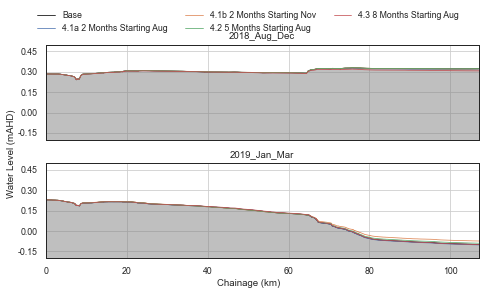

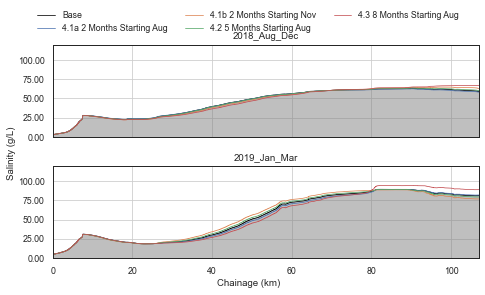

In [57]:
outpath = Path(ls_cfg.get('outpath'))
outpath.mkdir(exist_ok=True)
label_format = "{:,.2f}"
N_max_ticks = 5
# Loop through variables we're going to plot
for i, variable in enumerate(variables):
    if len(periods) % 9 == 0:
        ncols = 3
        nrows = int(len(periods)/3)
        height = 14
        width = 26
    elif (len(periods) % 9 == 0) & (len(periods) > 9):
        ncols = 3
        nrows = int(len(periods)/3)
        height = 24
        width = 35
    else:
        ncols = 1
        nrows = len(periods)
        height = 8  + 2/3 * len(periods)
        width = 17

    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(width / 2.54, height / 2.54),
        sharey=True,
        sharex=True,
    )

    # Find nice y scaling limits
    ymax = -99
    ymin = 99

    # Make a subplot for each location season
    for j, season_name in enumerate(periods):
        if len(periods) % 9 == 0:
            r = j // 3  # subplot row
            c = j % 3  # subplot col
            ax = axes[r][c]
        else:
            ax = axes[j]

        #ax.set_prop_cycle("color", sns.color_palette("Dark2", len(results)))
        ax.set_title(season_name)
        ax.grid("on")

        # Now plot the actual values from each result we have loaded
        for k, (scenario, df) in enumerate(dat.items()):
            col = [x for x in df.columns if season_name in x if variable in x][0]
            if j == 0:
                chainage = df["Chainage"]
            arr = df[col]
            #idx = [x for x in range(len(arr)) if x not in remove]
            idx = [x for x in range(len(arr))]

            #scn_id = scn.split("_")[0]
            if (k==0):
                ax.fill_between(
                    chainage[idx], arr[idx], -99, color="grey", alpha=0.5
                )
                ax.plot(
                    chainage[idx],
                    arr[idx],
                    label=scenario,
                    color="black",
                    linewidth=0.75,
                )
            #elif (k==1): #wind scenarios
            #    ax.plot(chainage[idx], arr[idx], label=scenario, linewidth=0.75, color="slategrey")
            else:
                ax.plot(chainage[idx], arr[idx], label=scenario, linewidth=0.75)

            ymax = max(ymax, arr[idx].max())
            ymin = min(ymin, arr[idx].min())

        # Get legend lables/handles once
        if j == 0:
            handles, labels = ax.get_legend_handles_labels()

    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.5, 1.07),
    )

    ax.set_xlim([0, chainage.max()])
    if ls_cfg.get('xlim'):
        ax.set_xlim(ls_cfg.get('xlim'))

    # Pretty up the tick labels
    if ls_cfg.get('ylim')[i]:  # Specified lims
        ax.set_ylim(ls_cfg.get('ylim')[i])
    else:
        ax.set_ylim(
            [
                np.round(ymin - 0.15 * abs(ymin), 2),
                np.round(ymax + 0.15 * abs(ymax), 2),
            ]
        )
    ax.yaxis.set_major_locator(mticker.MaxNLocator(N_max_ticks))
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_yticklabels([label_format.format(x) for x in ticks_loc])

    # Axis label styling
    ax_label = ls_cfg.get('ylabel')[i]
    fig.text(0.5, 0.00, "Chainage (km)", ha="center")
    fig.text(0.00, 0.5, ax_label, va="center", rotation="vertical")

    # Export figures
    print(f"Exporting figure - {variable}")
    plt.tight_layout()
    outfile = ls_cfg.get('resfile').replace('.xlsx','') + '_' + variable.replace(' ','_') + '.png'
    plt.savefig(
        outpath / outfile,
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200, facecolor='white', edgecolor='none'
    )